In [1]:
import h5py
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap']='jet'
matplotlib.rcParams['savefig.bbox']='tight' 
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter,MaxNLocator
from pathlib import Path
from MD_AE_tools.mode_decomposition import POD


import tensorflow as tf
tf.keras.backend.set_floatx('float32')
import configparser
import MD_AE_tools.ae_mode_evaluation as mode_eval
mse = tf.keras.losses.MeanSquaredError()
import MD_AE_tools.models.models_ff as modelff

from scipy import interpolate
from matplotlib import mlab
from tensorflow.keras.callbacks import ModelCheckpoint
# from MD_AE_tools.models.models import *
from MD_AE_tools.models.models_no_bias import *
from MD_AE_tools.models import model_evaluation
from MD_AE_tools.ae_mode_evaluation import equivalent_pca_energy
from project_specific_utils import read_pressure
from project_specific_utils.read_pressure import PIVdata
from project_specific_utils.plot import hide_contour_lines
from numpy import einsum
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=20000)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[2], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


In [2]:
# which_sets = [PIVdata.PIV7, PIVdata.PIV9, PIVdata.PIV12, PIVdata.PIV17]

# with h5py.File('./data/raw_pressure.h5','r') as hf:
#     print(hf.keys())
#     dt = np.squeeze(hf.get('dt'))
#     static_p = np.squeeze(hf.get('static_p'))
#     esp = np.array(hf.get('esp')).T
#     r = np.array(hf.get('r')).T
#     theta = np.array(hf.get('theta')).T
with h5py.File('./data/raw_pressure_long.h5','r') as hf:
    print(hf.keys())
    fs = np.squeeze(hf.get('fs'))
    static_p = np.squeeze(hf.get('static_p'))
    esp = np.array(hf.get('esp')).T
    r = np.array(hf.get('r')).T
    theta = np.array(hf.get('theta')).T


x=(np.cos(theta*np.pi/180).T)*r
y=(np.sin(theta*np.pi/180).T)*r 
x = x.flatten()
y = y.flatten()

## Parameters
nfft_psd = 2**14
overlap = nfft_psd/2
sampling_freq = fs
sensor_spacing = 11/1000
# sampling_freq = 720
# num_of_tests = len(which_sets)
D = 196.5 #mm
Uinf = 15 #m/s

# esp_allt = np.concatenate(esp[which_sets,:,:],axis=1)
esp_allt = esp
pmean = np.mean(esp_allt,axis=1).reshape(8,8)
prms = np.std(esp_allt,axis=1)
esp_allt.shape

# weightings
r1 = [0]
ri = np.zeros((1,8))
dr = r[0,1]-r[0,0]
dth = 2*np.pi/8
dA_weight = r*dr*dth
dA_weight = np.tile(dA_weight,8).T
dA_weight = dA_weight**0.5

<KeysViewHDF5 ['esp', 'fs', 'r', 'static_p', 'theta']>


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[[ 0.0004655  -0.00062117]]


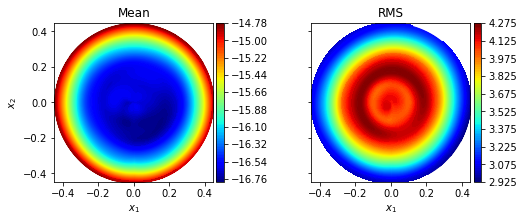

In [3]:
print(read_pressure.cop(pmean.reshape(-1,1)))
x_interp,y_interp,pmean_interp = read_pressure.interp(pmean,nint=15,filter=False)
_,_,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
rms_max = np.max(prms_interp)
rms_min = np.min(prms_interp)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7.5,2.8),sharey=True)
plt.subplots_adjust(wspace=0.1)
fig.tight_layout()

im1 = ax1.contourf(x_interp,y_interp,pmean_interp,levels=100,cmap='jet')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
ax1.set_aspect('equal')
ax1.set_title('Mean')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')

im2 = ax2.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet',vmax=rms_max,vmin=rms_min)
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="5%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
ax2.set_aspect('equal')
ax2.set_title('RMS')
ax2.set_xlabel('$x_1$')
hide_contour_lines(im1,im2)


# plt.savefig('_plots/exp_mean_rms.pdf')
plt.show()

### POD of data

In [4]:
pod_data = POD(esp_allt,weight=dA_weight)
modes_data,lam_data = pod_data.get_modes
a_data = pod_data.get_time_coefficient
_mean = np.mean(esp_allt,axis=1,keepdims=True)
num_modes = 28
reconstructed_pod = pod_data.reconstruct(num_modes)
print(f'Reconstruct with {num_modes} POD modes gives MSE {mse(reconstructed_pod-_mean,esp_allt-_mean)}')
rel_l2 = (np.sum((reconstructed_pod-_mean - (esp_allt-_mean))**2) / np.sum((esp_allt-_mean)**2))**0.5
print('relative error (no mean): ', rel_l2)

/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:194: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.weight == 'ones':


Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
Returning temporal coefficients for classic POD.
Returning temporal coefficients for classic POD.
Reconstruct with 28 POD modes gives MSE 0.624139130115509
relative error (no mean):  0.2075471510076113


In [5]:
reconstructed_pod = pod_data.reconstruct(28)
rel_l2 = (np.sum((reconstructed_pod-_mean - (esp_allt-_mean))**2) / np.sum((esp_allt-_mean)**2))**0.5
print(f'MSE {mse(reconstructed_pod-_mean,esp_allt-_mean)}, relative l2 {rel_l2}')

Returning temporal coefficients for classic POD.
MSE 0.624139130115509, relative l2 0.2075471510076113


### Data frequency

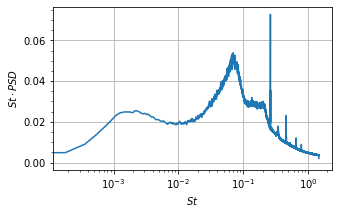

In [6]:
(nx,nt) = esp_allt.shape

pfluc = esp_allt - np.mean(esp_allt,axis=1,keepdims=True)
spp,freqs = mlab.psd(pfluc[0,:],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pfluc[i,:],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp = spp + spp1
spp_data = spp/nx
    
fig = plt.figure(figsize=(5,3))

plt.semilogx(st, st*spp_data)

plt.xlabel('$St$')
plt.ylabel('$St \cdot PSD$')
plt.minorticks_on()
plt.grid(axis='both')
# fig.savefig('_plots/exp_data_psd.pdf')
plt.show()

# Nz

In [7]:
with h5py.File('./_results/find_latent_dim_2to10.h5') as hf:
    loss_history = np.array(hf.get('loss_history'))
    loss_best = np.array(hf.get('loss_best'))
    latent_dim_list = list(hf.get('latent_dim_list'))
with h5py.File('./_results/find_latent_dim_16to24.h5') as hf:
    loss_history1 = np.array(hf.get('loss_history'))
    loss_best1 = np.array(hf.get('loss_best'))
    latent_dim_list1 = list(hf.get('latent_dim_list'))
loss_history = np.concatenate((loss_history,loss_history1),axis=0)
loss_best = np.concatenate((loss_best,loss_best1),axis=0)
latent_dim_list.extend(latent_dim_list1)
with h5py.File('./_results/find_latent_dim_4.h5') as hf:
    loss_history1 = np.array(hf.get('loss_history'))
    loss_best1 = np.array(hf.get('loss_best'))
    latent_dim_list1 = list(hf.get('latent_dim_list'))
loss_history = np.concatenate((loss_history[:,:,:4000],loss_history1),axis=0)
loss_best = np.concatenate((loss_best,loss_best1),axis=0)
latent_dim_list.extend(latent_dim_list1)
with h5py.File('./_results/find_latent_dim_6and9.h5') as hf:
    loss_history1 = np.array(hf.get('loss_history'))
    loss_best1 = np.array(hf.get('loss_best'))
    latent_dim_list1 = list(hf.get('latent_dim_list'))
loss_history = np.concatenate((loss_history,loss_history1[:,:,:4000]),axis=0)
loss_best = np.concatenate((loss_best,loss_best1),axis=0)
latent_dim_list.extend(latent_dim_list1)
with h5py.File('./_results/find_latent_dim_78to32.h5') as hf:
    loss_history1 = np.array(hf.get('loss_history'))
    loss_best1 = np.array(hf.get('loss_best'))
    latent_dim_list1 = list(hf.get('latent_dim_list'))
loss_history = np.concatenate((loss_history[:,:,:3000],loss_history1[:,:,:3000]),axis=0)
loss_best = np.concatenate((loss_best,loss_best1),axis=0)
latent_dim_list.extend(latent_dim_list1)

In [8]:
idx = np.argsort(latent_dim_list)
latent_dim_list = np.sort(latent_dim_list)
loss_best = loss_best[idx]
loss_history = loss_history[idx]
loss_std = np.std(loss_best,axis=1)
loss_mean = np.mean(loss_best,axis=1)
loss_min = np.min(loss_best,axis=1)
print('Nz tested: ',latent_dim_list)
print('Mean loss for each Nz: ',loss_mean)

Nz tested:  [ 2  3  4  5  6  7  8  9 10 16 19 20 24 28 32]
Mean loss for each Nz:  [5.26537609 3.74060019 3.21441086 3.87305125 2.95541179 1.98330069
 1.6527884  1.82422157 1.34590737 0.91530879 0.72366152 0.74816034
 0.54983566 0.58574033 0.80422658]


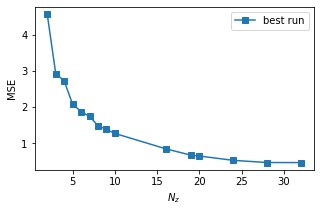

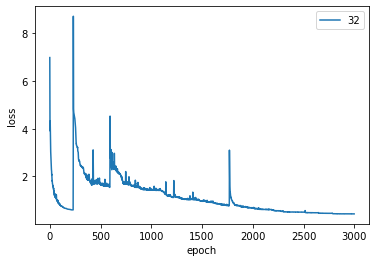

In [9]:
plt.figure(figsize=(5,3))
ax = plt.subplot(111)
# ax.errorbar(latent_dim_list,loss_mean,yerr=loss_std,capsize=5,label='mean')
ax.plot(latent_dim_list,loss_min,'s-',label='best run')
ax.set_xlabel('$N_z$')
ax.set_ylabel('MSE')
# ax.set_yscale('log')
plt.legend()
# plt.savefig('./_plots/ae_exp_convergence.pdf')


which_nz = -1
plt.figure()
plt.plot(loss_history[which_nz,1,:],label=str(latent_dim_list[which_nz])) #loss_history [nz,repeat,:]
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

# Model
Model parameters

In [10]:
[n,nt] = esp_allt.shape

## ae configuration
lmb = 0.00003 #1e-05 #regulariser
drop_rate = 0.014
act_fct = 'tanh'
batch_norm = True

## feedforward ae configuration
input_shape = n
encoder_layers = [128,256,256,128,64]
decoder_layers = [64,128,256,256,128]


## training
nb_epoch = 3000
batch_size = 300000
learning_rate = 0.0022


p_train = esp_allt - pmean.flatten()[:,np.newaxis]
p_train = p_train.T

In [11]:
lrschedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    learning_rate,
    100,
    t_mul=50,
    m_mul=0.9,
)

# AE

## Nz=2

In [7]:
latent_dim = 2

ae = modelff.Autoencoder(
    input_shape = input_shape,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    latent_dim = latent_dim,
    act_fct = act_fct,
    batch_norm = batch_norm,
    drop_rate = drop_rate,
    lmb = lmb
)
ae.summary()
ae.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse',run_eagerly=False)
ae.evaluate(p_train[:10,:],p_train[:10,:])
ae.load_weights(Path('_results/training/Nz2-1348382-repeat1/weights.h5'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 encoder (Encoder)           (None, 2)                 150912    
                                                                 
 decoder_1 (Decoder)         (None, 64)                150912    
                                                                 
Total params: 301,824
Trainable params: 298,496
Non-trainable params: 3,328
_________________________________________________________________
1/1 [==============================] - 1s 1s/step - loss: 8.5222


In [8]:
ae.decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_13 (Dense)            (None, 64)                128       
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 128)               8192      
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                          

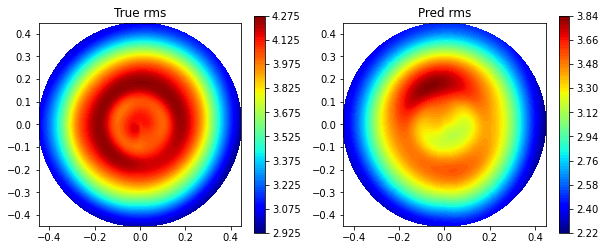

relative error:  0.49507318485510743
MSE:  3.5512986


In [9]:
pred = ae.predict(p_train,batch_size=batch_size).T
pred_rms = np.std(pred,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,pred_rms_interp = read_pressure.interp(pred_rms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('True rms')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,pred_rms_interp,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('Pred rms')
plt.colorbar(im1,ax=ax2)

plt.show()

rel_l2 = (np.sum((pred - p_train.T)**2) / np.sum(p_train.T**2))**0.5
error = np.mean((pred - p_train.T)**2)
print('relative error: ', rel_l2)
print('MSE: ', error)

In [10]:
pred_ae = pred.T
z_ae = ae.encoder.predict(p_train, batch_size=batch_size)

/tmp/ipykernel_1053264/413222077.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ym917/miniconda3/envs/MD-CNN-AE/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


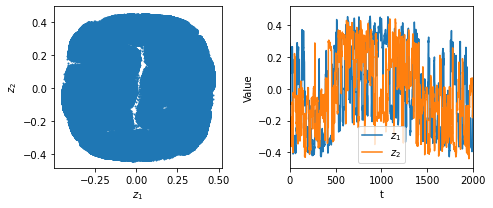

In [12]:
fig,axes = plt.subplots(1,2,figsize=(7,3))
axes[0].scatter(z_ae[:,0],z_ae[:,1],s=1)
axes[0].set(aspect='equal',xlabel='$z_1$',ylabel='$z_2$')
axes[1].plot(z_ae[:,0],label='$z_1$')
axes[1].plot(z_ae[:,1],label='$z_2$')
# axes[1].plot(z_ae[:,2],label='$z_3$')
axes[1].set(xlabel='t',ylabel='Value')
axes[1].legend()
axes[1].set(xlim=[0,2000])
# axes[0].set(xlim=[0.5,1.0], ylim=[-1.0,-0.3])
plt.tight_layout()
# plt.savefig('_plots/ae_cylinder2_latentbasic.pdf')

plt.show()

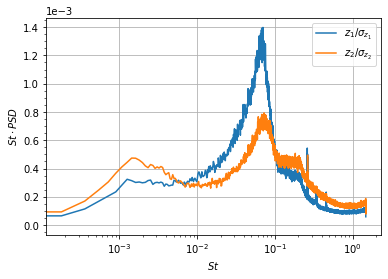

In [13]:

_std_z = np.std(z_ae,axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for i in range(2):
    
    spp,freqs = mlab.psd(z_ae[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)

    _label = 'z_{' + str(i+1) + '}/ \sigma_{z_{' + str(i+1) + '}}'
    ax.semilogx(st, st*spp/_std_z[i], label=f'${_label}$')
ax.minorticks_on()
ax.grid(axis='both')

# ax.set_ylim([0,np.max(st*spp)*1.1])
ax.set_xlabel('$St$')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax.set_ylabel('$St \cdot PSD$')
ax.legend()
# fig.savefig('./_plots/ae_exp2_latent_psd.pdf')
plt.show()

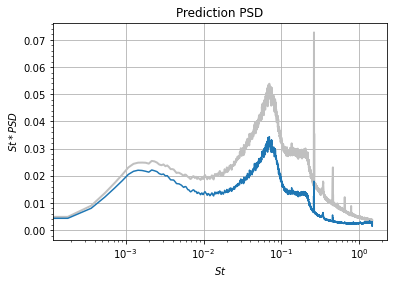

In [14]:
spp_2,freqs = mlab.psd(pred_ae[:,0],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pred_ae[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp_2 = spp_2 + spp1
spp_2 = spp_2/nx
    
plt.figure()

plt.semilogx(st, st*spp_data,label='data',c='#C0C0C0',linewidth=2)
plt.semilogx(st, st*spp_2)

plt.xlabel('$St$')
plt.ylabel('$St*PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.title('Prediction PSD')
plt.show()

Plots

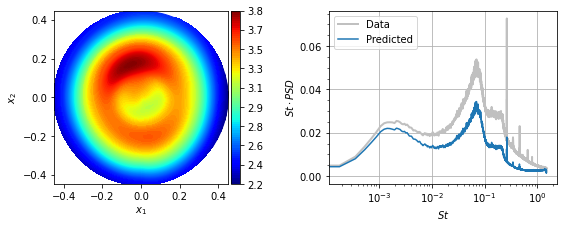

In [15]:
fig,axes = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

im = axes[0].contourf(x_interp,y_interp,pred_rms_interp,levels=100)
hide_contour_lines(im)
axes[0].set_aspect('equal')
ax_divider = make_axes_locatable(axes[0])
cax = ax_divider.append_axes('right',size='5%',pad='2%')
cbar = fig.colorbar(im,cax=cax)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')

axes[1].semilogx(st, st*spp_data,label='Data',c='#C0C0C0',linewidth=2)
axes[1].semilogx(st, st*spp_2,label='Predicted')

axes[1].set_xlabel('$St$')
axes[1].set_ylabel('$St \cdot PSD$')
axes[1].minorticks_on()
axes[1].grid(axis='both')
axes[1].legend()

# fig.savefig('./_plots/ae_exp2_pred.pdf')

plt.show()

In [16]:
pod2 = POD(pred_ae.T,weight=dA_weight)
modes2,lam2 = pod2.get_modes

/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:194: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.weight == 'ones':


Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


Returning temporal coefficients for classic POD.


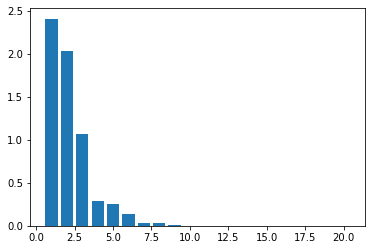

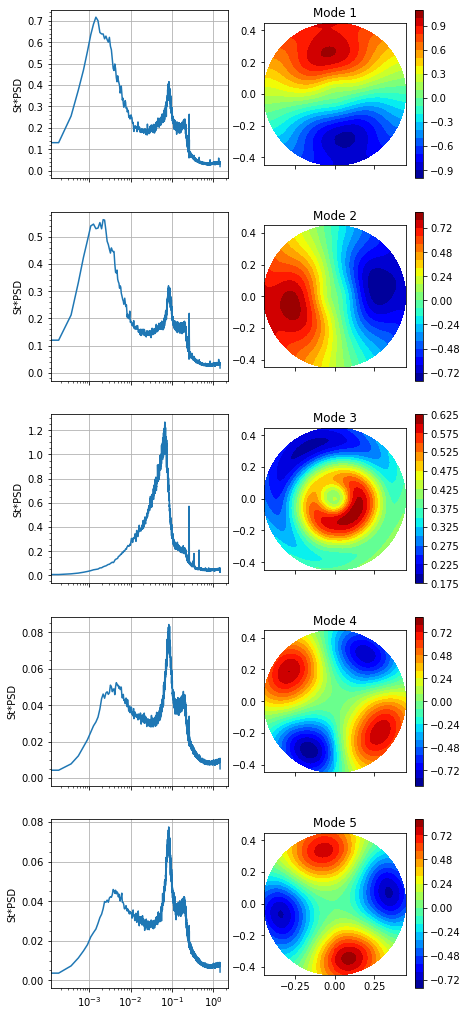

In [17]:
a2 = pod2.get_time_coefficient

plt.figure()
plt.bar(np.arange(1,21),lam2[:20])

fig,axes = plt.subplots(5,2,sharex='col',figsize=(7,18))

for i in range(5):
    m = i

    x_interp,y_interp,interpolated_values = read_pressure.interp(modes2[:,m])
    im = axes[i,1].contourf(x_interp,y_interp,interpolated_values,levels=20,cmap='jet')
    axes[i,1].set(aspect='equal',title=f'Mode {m+1}')
    plt.colorbar(im,ax=axes[i,1])

    # spp,freqs = mlab.psd(a[:2732,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    spp,freqs = mlab.psd(a2[:,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    st = (D/1000/Uinf)*freqs
    # for j in range(1,num_of_tests):
    #     spp1,_ = mlab.psd(a[2732*j:2732*(j+1),m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    #     spp = spp + spp1
    # spp = spp/num_of_tests
    axes[i,0].semilogx(st,st*spp,label=str(m+1))
    axes[i,0].set(ylabel='St*PSD')
    axes[i,0].minorticks_on()
    axes[i,0].grid('both')




plt.show()

### Decoder only

In [11]:
decoder2 = modelff.Decoder(
    output_shape=input_shape,
    layer_sizes=[64,256,256,256,256,256],
    latent_dim=2,
    act_fct='tanh',
    batch_norm=True,
)
decoder2.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse')
decoder2.evaluate(z_ae,p_train,batch_size=batch_size)
decoder2.load_weights(Path('./_results/decoderonly-Nz2-4121763-repeat0/weights.h5'))
decoder2.evaluate(z_ae,p_train,batch_size=batch_size)

15/15 [==============================] - 1s 64ms/step - loss: 3.2746


3.274592876434326

In [12]:
print(decoder2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 64)                128       
                                                                 
 batch_normalization_16 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 256)               16384     
                                                                 
 batch_normalization_17 (Bat  (None, 256)              1024      
 chNormalization)                                          

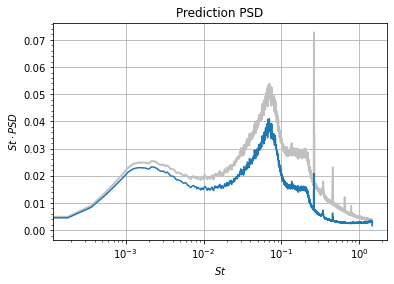

In [20]:
pred_decoder_only = decoder2.predict(z_ae,batch_size=batch_size)
spp_decoder_only,freqs = mlab.psd(pred_decoder_only[:,0],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pred_decoder_only[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp_decoder_only = spp_decoder_only + spp1
spp_decoder_only = spp_decoder_only/nx
    
plt.figure()

plt.semilogx(st, st*spp_data,label='data',c='#C0C0C0',linewidth=2)
plt.semilogx(st, st*spp_decoder_only)

plt.xlabel('$St$')
plt.ylabel('$St \cdot PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.title('Prediction PSD')
plt.show()

In [21]:
pod2_decoder = POD(pred_decoder_only.T,weight=dA_weight)
modes_decoder,lam_decoder = pod2_decoder.get_modes

/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:194: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.weight == 'ones':


Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


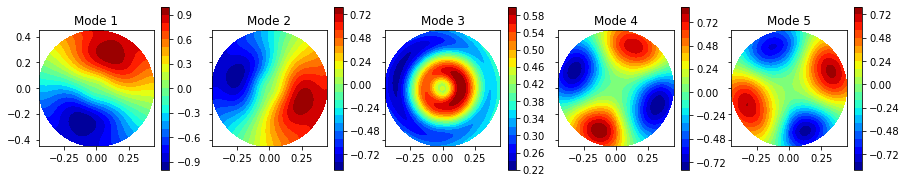

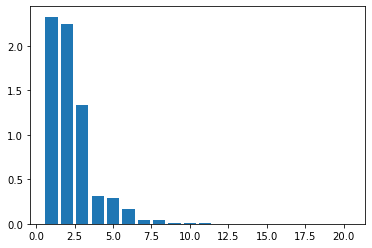

In [22]:
fig,axes = plt.subplots(1,5,sharex=True, sharey=True,figsize=(15,3))
for m in range(5):
    x_interp,y_interp,interpolated_values = read_pressure.interp(modes_decoder[:,m])
    im = axes[m].contourf(x_interp,y_interp,interpolated_values,levels=20,cmap='jet')
    axes[m].set(aspect='equal',title=f'Mode {m+1}')
    plt.colorbar(im,ax=axes[m])

plt.figure()
plt.bar(np.arange(1,21),lam_decoder[:20])
plt.show()

## Nz=3

In [23]:
latent_dim = 3

ae3 = modelff.Autoencoder(
    input_shape = input_shape,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    latent_dim = latent_dim,
    act_fct = act_fct,
    batch_norm = batch_norm,
    drop_rate = drop_rate,
    lmb = lmb
)
ae3.summary()
ae3.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse',run_eagerly=False)
ae3.evaluate(p_train[:10,:],p_train[:10,:])
ae3.load_weights(Path('_results/training/Nz3-4012573-repeat0/weights.h5'))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64)]              0         
                                                                 
 encoder_1 (Encoder)         (None, 3)                 150976    
                                                                 
 decoder_2 (Decoder)         (None, 64)                150976    
                                                                 
Total params: 301,952
Trainable params: 298,624
Non-trainable params: 3,328
_________________________________________________________________
1/1 [==============================] - 0s 283ms/step - loss: 8.5079


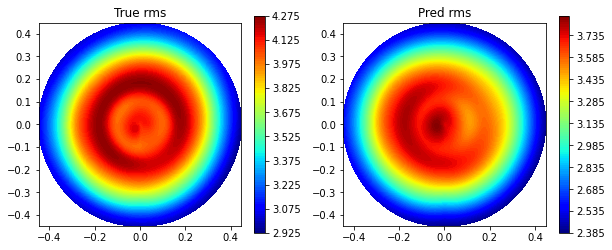

relative error:  0.43076852582501146
MSE:  2.6886625


In [24]:
pred3 = ae3.predict(p_train,batch_size=batch_size).T
pred3_rms = np.std(pred3,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,pred_rms_interp3 = read_pressure.interp(pred3_rms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('True rms')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,pred_rms_interp3,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('Pred rms')
plt.colorbar(im1,ax=ax2)

plt.show()

rel_l23 = (np.sum((pred3 - p_train.T)**2) / np.sum(p_train.T**2))**0.5
error3 = np.mean((pred3 - p_train.T)**2)
print('relative error: ', rel_l23)
print('MSE: ', error3)

In [25]:
pred_ae3 = pred3.T
z_ae3 = ae3.encoder.predict(p_train, batch_size=batch_size)

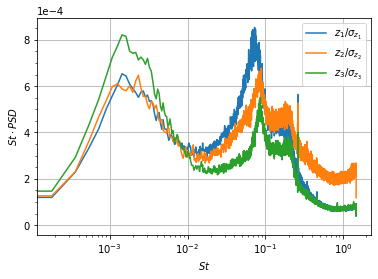

In [26]:
_std_z3 = np.std(z_ae3,axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for i in range(3):
    
    spp,freqs = mlab.psd(z_ae3[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)

    _label = 'z_{' + str(i+1) + '}/ \sigma_{z_{' + str(i+1) + '}}'
    ax.semilogx(st, st*spp/_std_z3[i], label=f'${_label}$')
ax.minorticks_on()
ax.grid(axis='both')

# ax.set_ylim([0,np.max(st*spp)*1.1])
ax.set_xlabel('$St$')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax.set_ylabel('$St \cdot PSD$')
ax.legend()
# fig.savefig('./_plots/ae_exp3_latent_psd.pdf')
plt.show()

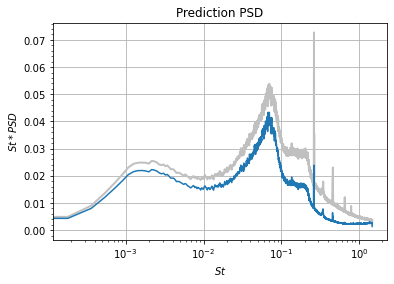

In [27]:
spp_3,freqs = mlab.psd(pred_ae3[:,0],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pred_ae3[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp_3 = spp_3 + spp1
spp_3 = spp_3/nx
    
plt.figure()

plt.semilogx(st, st*spp_data,label='Data',c='#C0C0C0',linewidth=2)
plt.semilogx(st, st*spp_3)

plt.xlabel('$St$')
plt.ylabel('$St*PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.title('Prediction PSD')
plt.show()

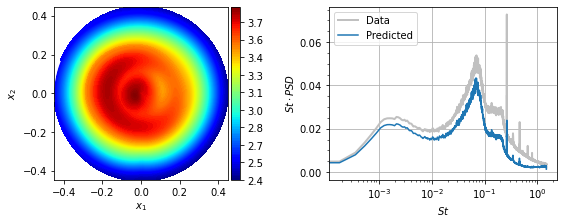

In [28]:
fig,axes = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

im = axes[0].contourf(x_interp,y_interp,pred_rms_interp3,levels=100)
hide_contour_lines(im)
axes[0].set_aspect('equal')
ax_divider = make_axes_locatable(axes[0])
cax = ax_divider.append_axes('right',size='5%',pad='2%')
cbar = fig.colorbar(im,cax=cax)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')

axes[1].semilogx(st, st*spp_data,label='Data',c='#C0C0C0',linewidth=2)
axes[1].semilogx(st, st*spp_3,label='Predicted')

axes[1].set_xlabel('$St$')
axes[1].set_ylabel('$St \cdot PSD$')
axes[1].minorticks_on()
axes[1].grid(axis='both')
axes[1].legend()

# fig.savefig('./_plots/ae_exp3_pred.pdf')

plt.show()

In [29]:
pod3 = POD(pred_ae3.T,weight=dA_weight)
modes3,lam3 = pod3.get_modes

/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:194: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.weight == 'ones':


Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


Returning temporal coefficients for classic POD.


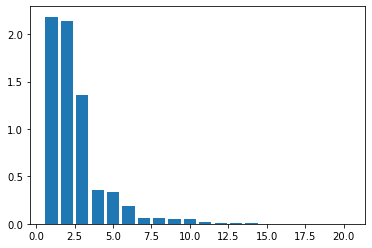

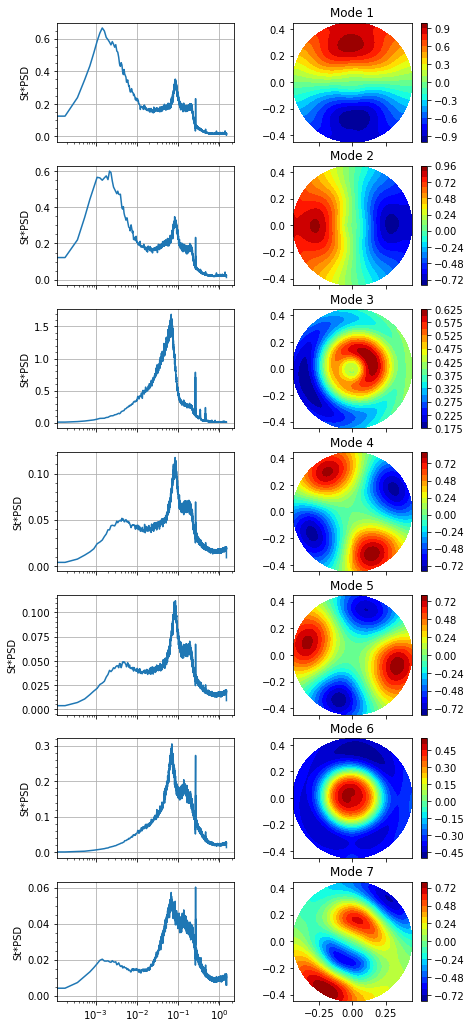

In [30]:
a3 = pod3.get_time_coefficient

plt.figure()
plt.bar(np.arange(1,21),lam3[:20])

fig,axes = plt.subplots(7,2,sharex='col',figsize=(7,18))

for m in range(7):

    

    x_interp,y_interp,interpolated_values = read_pressure.interp(modes3[:,m])
    im = axes[m,1].contourf(x_interp,y_interp,interpolated_values,levels=20,cmap='jet')
    axes[m,1].set(aspect='equal',title=f'Mode {m+1}')
    plt.colorbar(im,ax=axes[m,1])

    # spp,freqs = mlab.psd(a[:2732,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    spp,freqs = mlab.psd(a3[:,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    st = (D/1000/Uinf)*freqs
    # for j in range(1,num_of_tests):
    #     spp1,_ = mlab.psd(a[2732*j:2732*(j+1),m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    #     spp = spp + spp1
    # spp = spp/num_of_tests
    axes[m,0].semilogx(st,st*spp,label=str(m+1))
    axes[m,0].set(ylabel='St*PSD')
    axes[m,0].minorticks_on()
    axes[m,0].grid('both')




plt.show()

compare with Nz=2 normal and large decoder

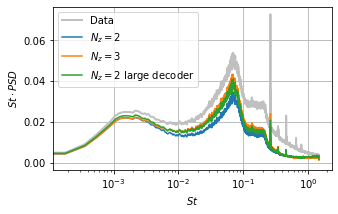

In [33]:
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.semilogx(st, st*spp_data,label='Data',c='#C0C0C0',linewidth=2)
ax.semilogx(st, st*spp_2,label='$N_z=2$')
ax.semilogx(st, st*spp_3,label='$N_z=3$')
ax.semilogx(st, st*spp_decoder_only,label='$N_z=2$ large decoder')

ax.grid('on')
ax.set_xlabel('$St$')
ax.set_ylabel('$St \cdot PSD$')

ax.legend()

# fig.savefig('./_plots/ae_exp2_decoderonly_pred.pdf')


# fig,ax = plt.subplots(1,1,figsize=(10,5))
# ax.bar(np.arange(1,64+1)-0.3, lam2/np.sum(lam2), width=0.3, label='$N_z=2$')
# ax.bar(np.arange(1,64+1), lam3/np.sum(lam3), width=0.3, label='$N_z=3$')
# ax.bar(np.arange(1,64+1)+0.3, lam_decoder/np.sum(lam_decoder), width=0.3,label='$N_z=2$ decoder only')

# ax.set_xlim([0,12])
# # ax.set_yscale('log')
# ax.legend()

plt.show()

## Nz=28

In [12]:
def get_equivalent_energy(b):

    new_lam = np.diag((1/(nt-1))* pod_data.Phi.T @ ((pod_data.Phi@b.T * dA_weight) @ ((b@pod_data.Phi.T)*dA_weight.T)) @ pod_data.Phi)

    return new_lam

In [13]:
latent_dim = 28

ae28 = modelff.Autoencoder(
    input_shape = input_shape,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    latent_dim = latent_dim,
    act_fct = act_fct,
    batch_norm = batch_norm,
    drop_rate = drop_rate,
    lmb = lmb
)
ae28.summary()
ae28.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse',run_eagerly=False)
ae28.evaluate(p_train[:10,:],p_train[:10,:])
ae28.load_weights(Path('_results/training/Nz28-2480964-repeat2/weights.h5'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64)]              0         
                                                                 
 encoder (Encoder)           (None, 28)                152576    
                                                                 
 decoder (Decoder)           (None, 64)                152576    
                                                                 
Total params: 305,152
Trainable params: 301,824
Non-trainable params: 3,328
_________________________________________________________________
1/1 [==============================] - 1s 1s/step - loss: 8.4021


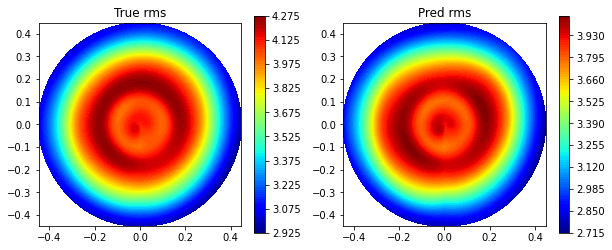

relative error:  0.2015108474818206
MSE:  0.5883629


In [14]:
pred28 = ae28.predict(p_train,batch_size=batch_size).T
pred28_rms = np.std(pred28,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,pred_rms_interp28 = read_pressure.interp(pred28_rms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('True rms')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,pred_rms_interp28,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('Pred rms')
plt.colorbar(im1,ax=ax2)

plt.show()

rel_l228 = (np.sum((pred28 - p_train.T)**2) / np.sum(p_train.T**2))**0.5
error28 = np.mean((pred28 - p_train.T)**2)
print('relative error: ', rel_l228)
print('MSE: ', error28)

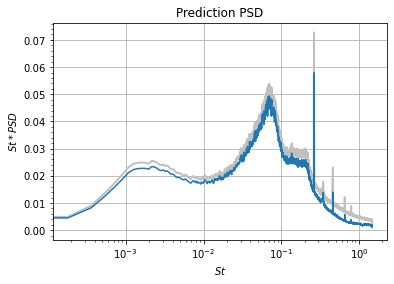

In [15]:
pred_ae28 = pred28.T
z_ae28 = ae28.encoder.predict(p_train, batch_size=batch_size)
spp_28,freqs = mlab.psd(pred_ae28[:,0],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pred_ae28[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp_28 = spp_28 + spp1
spp_28 = spp_28/nx
    
plt.figure()

plt.semilogx(st, st*spp_data,label='data',c='#C0C0C0',linewidth=2)
plt.semilogx(st, st*spp_28)

plt.xlabel('$St$')
plt.ylabel('$St*PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.title('Prediction PSD')
plt.show()

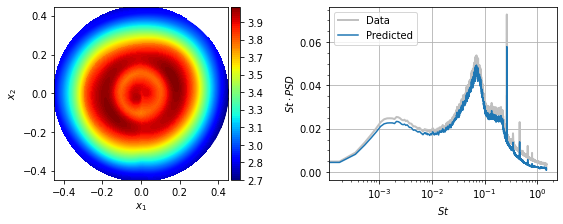

In [16]:
fig,axes = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)

im = axes[0].contourf(x_interp,y_interp,pred_rms_interp28,levels=100)
hide_contour_lines(im)
axes[0].set_aspect('equal')
ax_divider = make_axes_locatable(axes[0])
cax = ax_divider.append_axes('right',size='5%',pad='2%')
cbar = fig.colorbar(im,cax=cax)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')

axes[1].semilogx(st, st*spp_data,label='Data',c='#C0C0C0',linewidth=2)
axes[1].semilogx(st, st*spp_28,label='Predicted')

axes[1].set_xlabel('$St$')
axes[1].set_ylabel('$St \cdot PSD$')
axes[1].minorticks_on()
axes[1].grid(axis='both')
axes[1].legend()

# fig.savefig('./_plots/ae_exp28_pred.pdf')

plt.show()

In [17]:

# plt.figure()
# plt.violinplot(z_ae28, vert=True)

# plt.show()

Gradients

In [18]:
def local_partial_derivative(decoder,z,h,batch_size):

    #z[Nt,Nz]
    (nt,nz) = z.shape
    (_,n) = decoder.predict(z[[0],:]).shape

    dydz = np.zeros((nz,nt,n))

    for i in range(nz):

        print(i)

        hi = np.zeros((1,nz))
        hi[0,i] = h #[1,Nz]

        z_left = z + hi
        z_right = z - hi

        f_z_left = decoder.predict(z_left, batch_size=batch_size)
        f_z_right = decoder.predict(z_right, batch_size=batch_size)
        dydz_i = (f_z_left - f_z_right) / (2*h) #[Nt,N]

        dydz[i,:,:] = dydz_i
    
    return dydz


In [19]:
dydz28 = local_partial_derivative(ae28.decoder,z_ae28,0.01,batch_size)
dydz28.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


(28, 4320000, 64)

In [20]:
_std = jnp.std(z_ae28,axis=0,keepdims=True) #[1,28]

In [21]:
dydz28 = jnp.asarray(dydz28)
dbdz28 = jnp.einsum('z t n, n m -> z t m', dydz28, modes_data)
dbdz28.shape

(28, 4320000, 64)

In [22]:
dbdz28_normalised = dbdz28 / _std.T[:,:,np.newaxis]

Get averaged rate of change

$\epsilon_{ij} = \frac{1}{N_t} \sum_{t}^{N_t} | \frac{dB_j^t}{dz_i^t} |$

In [23]:
num_modes_to_keep = 10
# dbdz28 has shape [nz,nt,m]
# avgbz = jnp.mean(jnp.abs(dbdz28_normalised),axis=1)
avgbz = jnp.mean(jnp.abs(dbdz28),axis=1)
avgbz.shape

(28, 64)

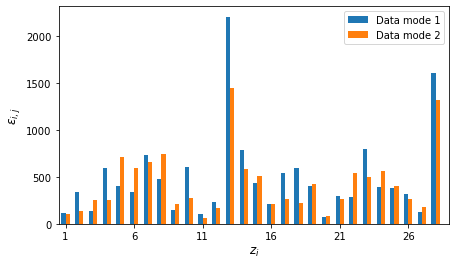

In [24]:
plt.figure(figsize=(7,4))
_plt_m = np.arange(28)+1
plt.bar(_plt_m-0.15, avgbz[:,0], width=0.3, label=f'Data mode 1')
plt.bar(_plt_m+0.15, avgbz[:,1], width=0.3, label=f'Data mode 2')
# plt.bar(_plt_m+0.3, avgbz[:,2], width=0.3, label=f'Data mode 3')
# plt.bar(_plt_m-0.15, avgbz[:,2], width=0.3, label=f'Data mode 3')
# plt.bar(_plt_m+0.15, avgbz[:,5], width=0.3, label=f'Data mode 6')
plt.legend()
plt.ylabel('$\epsilon_{i,j}$',fontsize='large')
plt.xlabel('$z_i$', fontsize='large')
plt.xlim([0.5,29])
plt.xticks(np.arange(1,28,5))
# plt.savefig('./_plots/ae_exp28_rate_of_change_mode1and2.pdf')
plt.show()

Select latent variables

/home/ym917/miniconda3/envs/MD-CNN-AE/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3613: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


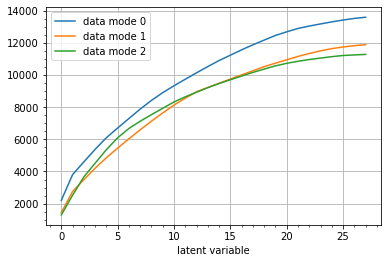

The most important 2 latent variables for data mode: 
    [12 27]
    [12 27]
    [18 20]
    [18  5]


In [25]:
z_index = np.arange(28)

sort0 = np.flip(np.argsort(avgbz[:,0]))
sort1 = np.flip(np.argsort(avgbz[:,1]))
sort2 = np.flip(np.argsort(avgbz[:,2]))
sort5 = np.flip(np.argsort(avgbz[:,5]))

dbdz_0_sorted = avgbz[:,0][sort0]
dbdz_1_sorted = avgbz[:,1][sort1]
dbdz_2_sorted = avgbz[:,2][sort2]
dbdz_5_sorted = avgbz[:,5][sort2]

plt.figure()
plt.plot(np.cumsum(dbdz_0_sorted),label='data mode 0')
plt.plot(np.cumsum(dbdz_1_sorted),label='data mode 1')
plt.plot(np.cumsum(dbdz_2_sorted),label='data mode 2')
plt.legend()
plt.minorticks_on()
plt.grid('both')
plt.xlabel('latent variable')
plt.show()

how_many_z = 2
best_z_0 = sort0[:how_many_z]
best_z_1 = sort1[:how_many_z]
best_z_2 = sort2[:how_many_z]
best_z_5 = sort5[:how_many_z]

print(f'The most important {how_many_z} latent variables for data mode: ')
print(f'    {best_z_0}')
print(f'    {best_z_1}')
print(f'    {best_z_2}')
print(f'    {best_z_5}')

MSE is 10.638169288635254


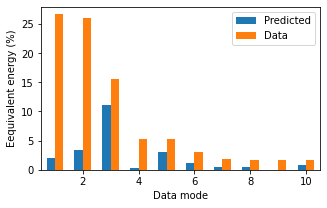

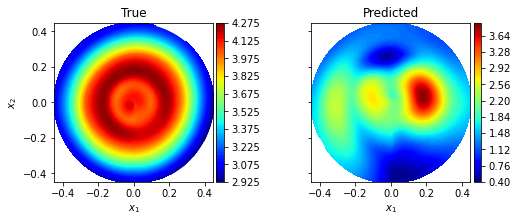

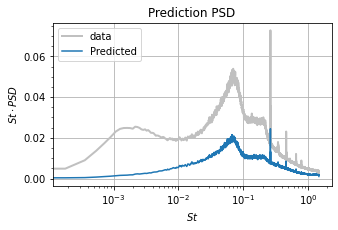

In [26]:
## For third mode

z_masked = np.zeros_like(z_ae28)
z_masked[:,best_z_2] = z_ae28[:,best_z_2]
# z_masked[:,5] = z_ae28[:,5]

pred_mode2 = ae28.decoder.predict(z_masked,batch_size=batch_size)
print(f'MSE is {np.mean((pred_mode2-pred_ae28)**2)}')


## equivalent energy
b_mode2 = jnp.einsum('t n, n m -> t m', pred_mode2, pod_data.Phi)
lam_pred_mode2 = get_equivalent_energy(b_mode2)

fig = plt.figure(figsize=(5,3))
plt.bar(np.arange(64)+1-0.15,100*lam_pred_mode2/np.sum(lam_data),width=0.3,label='Predicted')
plt.bar(np.arange(64)+1+0.15,100*lam_data/np.sum(lam_data),width=0.3,label='Data')
# plt.xlim([-1,10])
plt.xlabel('Data mode')
plt.ylabel('Eequivalent energy (%)')
plt.xlim([0.5,10.5])
plt.legend()
# fig.savefig('./_plots/ae_exp28_equivalent_energy_mode3.pdf')


## interpolated rms image
plt_rms = np.std(pred_mode2.T,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,plt_rms_interp = read_pressure.interp(plt_rms,nint=15,filter=False)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7.5,2.8),sharey=True)
plt.subplots_adjust(wspace=0.1)
fig.tight_layout()
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
ax1.set_aspect('equal')
ax1.set_title('True')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
im2 = ax2.contourf(x_interp,y_interp,plt_rms_interp,levels=100,cmap='jet')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="5%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
ax2.set_aspect('equal')
ax2.set_title('Predicted')
ax2.set_xlabel('$x_1$')
hide_contour_lines(im1,im2)
# fig.savefig('./_plots/ae_exp28_pred_rms.pdf')


## frequency
spp,freqs = mlab.psd(pred_mode2[:,0],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pred_mode2[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp = spp + spp1
spp = spp/nx
    
fig = plt.figure(figsize=(5,3))

plt.semilogx(st, st*spp_data,label='data',c='#C0C0C0',linewidth=2)
plt.semilogx(st, st*spp,label='Predicted')

plt.xlabel('$St$')
plt.ylabel('$St \cdot PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.title('Prediction PSD')
plt.legend()
# fig.savefig('./_plots/ae_exp28_pred_psd_mode3.pdf')

plt.show()

MSE is 9.061537742614746


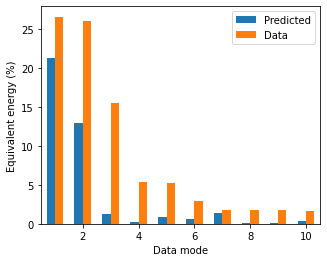

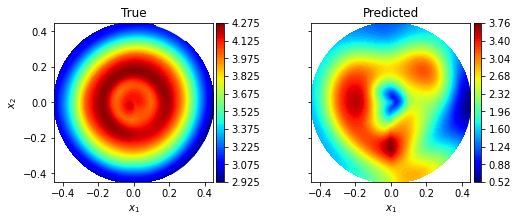

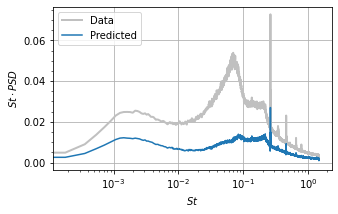

In [27]:
## For mode 1&2

z_masked = np.zeros_like(z_ae28)
z_masked[:,best_z_0] = z_ae28[:,best_z_0]
z_masked[:,best_z_1] = z_ae28[:,best_z_1]
pred_mode0to1 = ae28.decoder.predict(z_masked,batch_size=batch_size)
print(f'MSE is {np.mean((pred_mode0to1-pred_ae28)**2)}')

b_mode0to1 = jnp.einsum('t n, n m -> t m', pred_mode0to1, pod_data.Phi)
lam_pred_mode0to1 = get_equivalent_energy(b_mode0to1)

fig = plt.figure(figsize=(5,4))
plt.bar(np.arange(64)+1-0.15,100*lam_pred_mode0to1/np.sum(lam_data),width=0.3,label='Predicted')
plt.bar(np.arange(64)+1+0.15,100*lam_data/np.sum(lam_data),width=0.3,label='Data')
# plt.xlim([-1,10])
plt.xlabel('Data mode')
plt.ylabel('Equivalent energy (%)')
plt.xlim([0.5,10.5])
plt.legend()
# fig.savefig('./_plots/ae_exp28_equivalent_energy_mode1and2.pdf')


## interpolated rms image
plt_rms = np.std(pred_mode0to1.T,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,plt_rms_interp = read_pressure.interp(plt_rms,nint=15,filter=False)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7.5,2.8),sharey=True)
plt.subplots_adjust(wspace=0.1)
fig.tight_layout()
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
ax1.set_aspect('equal')
ax1.set_title('True')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
im2 = ax2.contourf(x_interp,y_interp,plt_rms_interp,levels=100,cmap='jet')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="5%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
ax2.set_aspect('equal')
ax2.set_title('Predicted')
ax2.set_xlabel('$x_1$')
hide_contour_lines(im1,im2)
# fig.savefig('./_plots/ae_exp28_pred_rms1and2.pdf')


## frequency
spp,freqs = mlab.psd(pred_mode0to1[:,0],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pred_mode0to1[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp = spp + spp1
spp = spp/nx
    
fig = plt.figure(figsize=(5,3))

plt.semilogx(st, st*spp_data,label='Data',c='#C0C0C0',linewidth=2)
plt.semilogx(st, st*spp,label='Predicted')

plt.xlabel('$St$')
plt.ylabel('$St \cdot PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.legend()
# plt.title('Prediction PSD')

# fig.savefig('./_plots/ae_exp28_pred_psd_mode1and2.pdf')

plt.show()

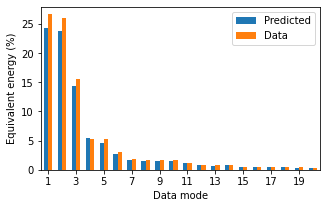

In [28]:
## Control group

b_mode_all = jnp.einsum('t n, n m -> t m', pred_ae28, pod_data.Phi)
# lam_pred_mode_all = (1 / (nt - 1)) * np.sum((b_mode_all.T * (dA_weight * b_mode_all.T)), axis=1)
lam_pred_mode_all = get_equivalent_energy(b_mode_all)



# lam_pred_mode_all = jnp.var(b_mode_all,axis=0)

plt.figure(figsize=(5,3))
plt.bar(np.arange(64)+1-0.15,100*lam_pred_mode_all/np.sum(lam_data),width=0.3,label='Predicted')
# plt.bar(np.arange(64)+0.15,new_a,width=0.3,label='Data_test')
plt.bar(np.arange(64)+1+0.15,100*lam_data/np.sum(lam_data),width=0.3,label='Data')
plt.xlim([0.5,20.5])
plt.xlabel('Data mode')
plt.ylabel('Equivalent energy (%)')
plt.legend()
plt.xticks(np.arange(1,21,2))
# plt.savefig('./_plots/ae_exp28_control_equivalent_energy.pdf')
plt.show()

In [29]:
pod_new_28 = POD(pred_mode0to1.T,weight=dA_weight)
modes_new_28,lam_new_28 = pod_new_28.get_modes
a_new_28 = pod_new_28.get_time_coefficient

/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:194: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.weight == 'ones':


Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
Returning temporal coefficients for classic POD.


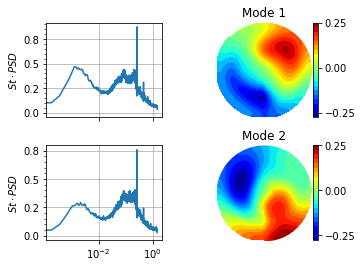

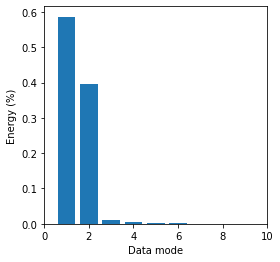

In [31]:

fig,axes = plt.subplots(2,2,sharex='col',figsize=(5,4))
fig.subplots_adjust(wspace=0.4,hspace=0.3)

for m in range(2):

    

    x_interp,y_interp,interpolated_values = read_pressure.interp(pod_new_28.Phi[:,m])
    im = axes[m,1].contourf(x_interp,y_interp,interpolated_values,levels=20,cmap='jet')
    hide_contour_lines(im)
    axes[m,1].set(aspect='equal',title=f'Mode {m+1}')
    axes[m,1].axis('off')
    ax_divider = make_axes_locatable(axes[m,1])
    cax = ax_divider.append_axes('right',size='5%',pad='2%')
    cbar = fig.colorbar(im,cax=cax)
    tick_locator = MaxNLocator(nbins=2)
    cbar.locator = tick_locator
    cbar.update_ticks()

    # spp,freqs = mlab.psd(a[:2732,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    spp,freqs = mlab.psd(a_new_28[:,m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    st = (D/1000/Uinf)*freqs
    # for j in range(1,num_of_tests):
    #     spp1,_ = mlab.psd(a[2732*j:2732*(j+1),m],Fs=sampling_freq,NFFT=nfft_psd,noverlap=overlap)
    #     spp = spp + spp1
    # spp = spp/num_of_tests
    axes[m,0].semilogx(st,st*spp,label=str(m+1))
    axes[m,0].set(ylabel='$St \cdot PSD$')
    axes[m,0].minorticks_on()
    axes[m,0].grid('both')
    axes[m,0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

# fig.savefig('./_plots/ae_exp28_pred_modes.pdf')



plt.figure(figsize=(4,4))
plt.bar(np.arange(1,64+1),lam_new_28/np.sum(lam_new_28))
plt.xlabel('Data mode')
plt.ylabel('Energy (%)')
plt.xlim([0,10])
# fig.savefig('./_plots/ae_exp28_pred_modes_lam.pdf')

# print(100*lam_new_28[:3]/np.sum(lam_new_28))

plt.show()

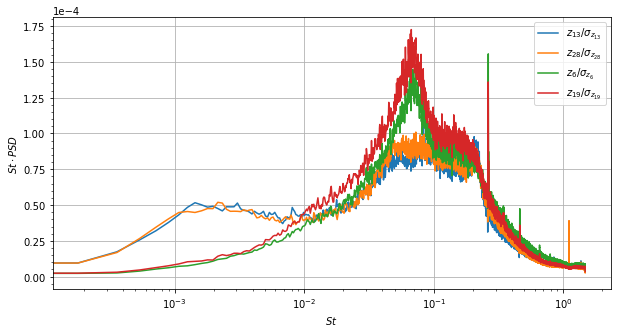

In [16]:
_std_z28 = np.std(z_ae28,axis=0)

fig, ax = plt.subplots(1,1,figsize=(10,5))
for i in [12,27,5,18]:

    zi = i
    
    spp,freqs = mlab.psd(z_ae28[:,zi],Fs=fs,NFFT=nfft_psd,noverlap=overlap)

    _label = 'z_{' + str(zi+1) + '}/ \sigma_{z_{' + str(zi+1) + '}}'
    ax.semilogx(st, st*spp/_std_z28[i], label=f'${_label}$')
ax.minorticks_on()
ax.grid(axis='both')

# ax.set_ylim([0,np.max(st*spp)*1.1])
ax.set_xlabel('$St$')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

ax.set_ylabel('$St \cdot PSD$')
ax.legend()
# fig.savefig('./_plots/ae_exp3_latent_psd.pdf')
plt.show()